#ECE6953-DEEP LEARNING FINAL PROJECT
Peiqi Su
ps4702

##1.Install and import necessary dependencies, libraries and read in dataset

In [1]:
!pip3 install chardet

In [2]:
!pip3 install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.4 MB/s eta 0:00:00


In [47]:
import chardet
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf
import tensorflow_hub as tf_hub
import tensorflow_text as tf_text
import chardet
import matplotlib.pyplot as plt
import seaborn as sn
from wordcloud import WordCloud as wc
from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split
from keras import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

Upload UCI_spam_collection.csv to colab before loading it.

Standard utf-8 encoding does not work, need to check using character encoding detector.

In [4]:
with open('UCI_spamham_collection.csv', 'rb') as in_file: result = chardet.detect(in_file.read())

Store the encoding type.

In [5]:
encoding = result['encoding']

read in data using known encoding type.

In [6]:
data = pd.read_csv('UCI_spamham_collection.csv', encoding = encoding, delimiter = ",")

##2.Retriving information and preprocessing data

We can see one row consists of a preceding label and the texts.

In [7]:
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


There are three columns with garbage values and need to be removed.

In [8]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [9]:
data.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
data['label'] = data['label'].map({'spam':1, 'ham':0})
print("The dataset has", data[data['label'] == 0].shape[0], "ham messages.")
print("The dataset has", data[data['label'] == 1].shape[0], "spam messages.")

The dataset has 4825 ham messages.
The dataset has 747 spam messages.


We can clearly see patterns of spam messages from the below word cloud, will the model we train be capable of this?

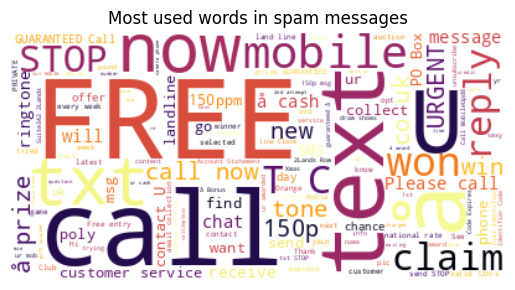

In [10]:
text = " ".join(i for i in data[data['label'] == 1].message)
stopwords = set(STOPWORDS)
wordcloud = wc(stopwords=stopwords, background_color="white", colormap = 'inferno').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f'Most used words in spam messages')
plt.show()

Distributions of messages.

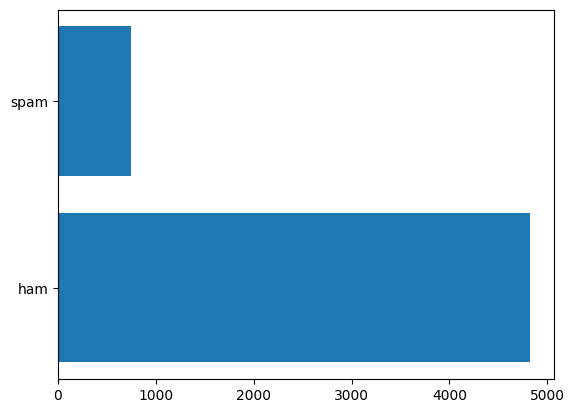

In [11]:
height = [data[data['label'] == 0].shape[0], data[data['label'] == 1].shape[0]]
bars = ('ham', 'spam')
y_pos = np.arange(len(bars))
plt.barh(y_pos, height)
plt.yticks(y_pos, bars)
plt.show()

##3.Training and Evaluation

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.3, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [19]:
bert_preprocess = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Load in BERT model

In [34]:
message_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='message')
preprocessed_message = bert_preprocess(message_input)
outputs = bert_encoder(preprocessed_message)
layer = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)
model = tf.keras.Model(inputs=[message_input], outputs = [layer])

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics.BinaryAccuracy(name='accuracy'))

In [36]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10)

Epoch 1/10
86/86 [==============================] - 51s 572ms/step - loss: 0.4058 - accuracy: 0.8286 - val_loss: 0.3130 - val_accuracy: 0.8726
Epoch 2/10
86/86 [==============================] - 48s 566ms/step - loss: 0.2996 - accuracy: 0.8656 - val_loss: 0.2556 - val_accuracy: 0.8769
Epoch 3/10
86/86 [==============================] - 48s 562ms/step - loss: 0.2551 - accuracy: 0.8875 - val_loss: 0.2294 - val_accuracy: 0.9034
Epoch 4/10
86/86 [==============================] - 48s 566ms/step - loss: 0.2304 - accuracy: 0.9000 - val_loss: 0.2060 - val_accuracy: 0.9145
Epoch 5/10
86/86 [==============================] - 49s 567ms/step - loss: 0.2078 - accuracy: 0.9143 - val_loss: 0.1893 - val_accuracy: 0.9154
Epoch 6/10
86/86 [==============================] - 49s 567ms/step - loss: 0.1927 - accuracy: 0.9223 - val_loss: 0.1823 - val_accuracy: 0.9120
Epoch 7/10
86/86 [==============================] - 49s 567ms/step - loss: 0.1814 - accuracy: 0.9293 - val_loss: 0.1658 - val_accuracy: 0.9299

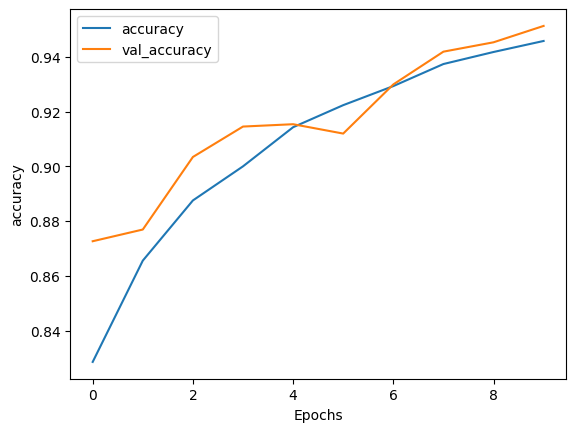

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

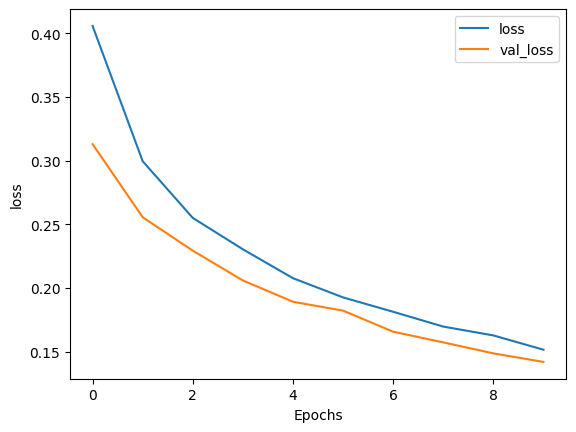

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [41]:
model.evaluate(X_test, y_test)

53/53 [==============================] - 17s 311ms/step - loss: 0.1424 - accuracy: 0.9569


[0.14235849678516388, 0.9569377899169922]

In [42]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

53/53 [==============================] - 17s 325ms/step


In [43]:
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
disp.show()

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')

Display the confusion matrix to have a better understanding of the performance

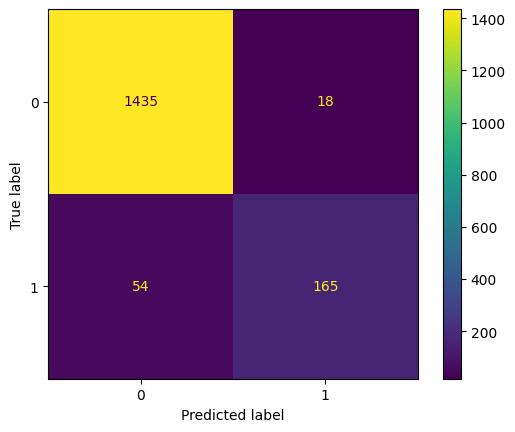

In [49]:
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()